<a href="https://colab.research.google.com/github/neha23nagaraj/Movie-Audience-Score-Prediction/blob/main/Part2_WM_FP_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WebMining/rottentomatoes_movies.csv')
df = df[df['Audience Score'].notna()]
df['label'] = df['Audience Score'].apply(lambda x: 1 if x >= 50 else 0)

In [ ]:
df['Audience_Review_Count'] = df['Audience_Review_Count'] * 1000

In [ ]:
def duration_to_minutes(d):
    try:
        h = int(re.search(r'(\d+)h', d).group(1)) if 'h' in d else 0
        m = int(re.search(r'(\d+)m', d).group(1)) if 'm' in d else 0
        return h * 60 + m
    except:
        return np.nan

df['Duration_mins'] = df['Duration'].astype(str).apply(duration_to_minutes)

In [ ]:
df['Rating'] = df['Rating'].fillna('Unknown')
df['Rating_encoded'] = LabelEncoder().fit_transform(df['Rating'])

df['Genre'] = df['Genre'].astype(str).str.replace(r'/+', '', regex=True).str.strip()
genre_dummies = df['Genre'].str.get_dummies(sep=', ')

df['Director'] = df['Director'].fillna("Unknown")
top_directors = df['Director'].value_counts().head(10).index
df['top_director'] = df['Director'].apply(lambda x: x if x in top_directors else "Other")
director_dummies = pd.get_dummies(df['top_director'], prefix='dir')

df['has_number_in_title'] = df['Title'].str.contains(r'\d').astype(int)

In [ ]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Synopsis'].fillna("")).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])

In [ ]:
X = pd.concat([
    df[['Rating_encoded', 'Critic_Score', 'Critic_Review_Count', 'Audience_Review_Count',
        'Duration_mins', 'has_number_in_title']],
    genre_dummies,
    director_dummies,
    tfidf_df
], axis=1).fillna(0)

y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=0.35/0.65,  # imbalance adjustment
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_acc = xgb_model.score(X_test, y_test)
print("✅ XGBoost Accuracy:", round(xgb_acc * 100, 2), "%")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:14:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy: 80.0 %


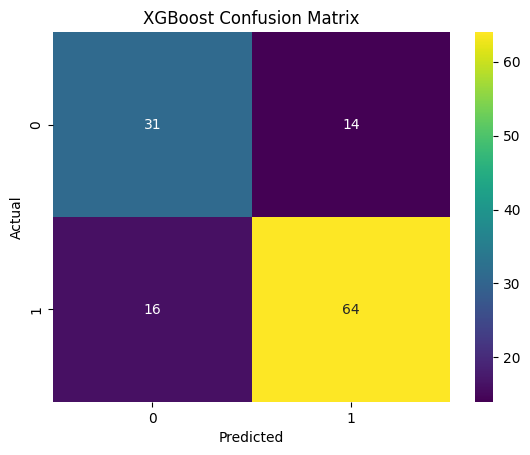

In [ ]:
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()